# BA820 M4 - Refinement & Deepening
# Repetition or Structure? Exploring Color Consistency in Bob Ross Paintings


In M2, I shifted the research focus from simple color distribution analysis to **multimodal analysis**, specifically exploring **whether color recipes extracted through unsupervised learning align with the textual semantics in painting titles**. On the other hand, I completed core data cleaning and feature engineering, such as transforming color data into a Boolean matrix and extracting painting complexity features, and created a color correlation heatmap for initial EDA.

In M3 (SQ2), I used the **Apriori algorithm** to analyze Bob Ross’s color combinations. I found s**trong local co-occurrence patterns in his palette**. For example, the high lift value of the “Winter Recipe” (Phthalo Blue + Prussian Blue) shows that these colors frequently appear together and form a clear color module.


**M4 Refinement Goals:**

Rather than searching for new patterns, M4 focuses on rigorously testing whether the previously identified structure is stable, model-independent, and semantically grounded.
* **Rigorous Experimentation:**
  In this stage, I run a sensitivity analysis to check whether the thresholds we chose in M3 were reasonable and whether the discovered rules are stable.

* **Methodological Cross-Validation:**
  I introduce Hierarchical Clustering as another mathematical approach to see if the same color modules appear from a different perspective.

* **Unstructured Data Integration:**
  I also apply text mining (Text Mining + K-Means) to the painting titles to examine whether the local color modules align with meaningful semantic themes.



# Data Preparation

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import re

#load Dataset
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/bob_ross.csv'

In [12]:
try:
    df = pd.read_csv(file_path)
except FileNotFoundError as e:
    raise FileNotFoundError(f"File not found: {file_path}") from e

df.columns = (
    df.columns
      .str.strip()
      .str.replace(r'\r\n', '', regex=True)
      .str.replace(r'\n', '', regex=True)
)

#Boolean Matrix Conversion
non_color_cols = [
    'painting_index', 'img_src', 'painting_title', 'season',
    'episode', 'num_colors', 'youtube_src', 'colors', 'color_hex', 'Unnamed: 0'
]

drop_cols = [c for c in non_color_cols if c in df.columns]
color_columns = [c for c in df.columns if c not in drop_cols]

for col in color_columns:
    if df[col].dtype == 'object':
        df[col] = (
            df[col].astype(str)
                 .str.upper()
                 .replace({'TRUE': True, 'FALSE': False})
        )
    df[col] = df[col].astype(bool)

# Feature Engineering
median_colors = df['num_colors'].median()

def categorize_complexity(num):
    return 'Complex' if num >= median_colors else 'Simple'

df['complexity'] = df['num_colors'].apply(categorize_complexity)

#Text Data Extraction
df['painting_title'] = df['painting_title'].astype(str)

df['clean_title'] = (
    df['painting_title']
      .str.lower()
      .str.replace(r'[^\w\s]', '', regex=True)
)

color_df = df[color_columns].copy()

preview_cols = ['painting_title', 'clean_title', 'num_colors', 'complexity'] + color_columns[:3]
display(df[preview_cols].head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,painting_title,clean_title,num_colors,complexity,Black_Gesso,Bright_Red,Burnt_Umber
0,A Walk in the Woods,a walk in the woods,8,Simple,False,True,False
1,Mt. McKinley,mt mckinley,8,Simple,False,True,False
2,Ebony Sunset,ebony sunset,9,Simple,True,True,False
3,Winter Mist,winter mist,3,Simple,False,False,False
4,Quiet Stream,quiet stream,8,Simple,False,True,False


# Rigorous Experimentation - Sensitivity Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

X_proc = color_df.astype(bool)

support_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.10, 0.12, 0.15]
lift_list = [1.0, 1.2, 1.5, 2.0]
conf_list = [0.1, 0.2]

rows = []

for min_sup in support_list:
    frequent_itemsets = apriori(X_proc, min_support=min_sup, use_colnames=True)

    if frequent_itemsets.empty:
        continue

    try:
        base_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.0)
    except ValueError:
        continue

    for min_conf in conf_list:
        for min_lift in lift_list:

            filtered_rules = base_rules[(base_rules['lift'] >= min_lift) & (base_rules['confidence'] >= min_conf)]
            num_rules = len(filtered_rules)

            winter_survives = False
            for idx, row in filtered_rules.iterrows():
                combined_colors = set(row['antecedents']).union(set(row['consequents']))
                combined_str = [str(c).lower().replace(' ', '_') for c in combined_colors]

                if any('phthalo' in s for s in combined_str) and any('prussian' in s for s in combined_str):
                    winter_survives = True
                    break

            rows.append({
                "min_support": min_sup,
                "min_confidence": min_conf,
                "min_lift": min_lift,
                "num_rules": num_rules,
                "winter_survives": winter_survives
            })

results = pd.DataFrame(rows)

summary_df = results[results['min_confidence'] == 0.1].copy()

display(summary_df.head(10))
#viz
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary_df, x='min_support', y='num_rules', hue='min_lift', marker='o', palette='viridis')

survived_data = summary_df[summary_df['winter_survives'] == True]
if not survived_data.empty:
    sns.scatterplot(data=survived_data, x='min_support', y='num_rules', color='red', s=100, zorder=5, label='Winter Blue Survives')

plt.title('Apriori Sensitivity Analysis: Rule Count & Module Survival', fontsize=14, fontweight='bold')
plt.xlabel('Minimum Support Threshold', fontsize=12)
plt.ylabel('Number of Rules Generated', fontsize=12)
plt.axvline(x=0.05, color='gray', linestyle='--', label='M3 Baseline (Support=0.05)')
plt.legend(title='Min Lift')
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

optimal_candidates = results[(results['winter_survives'] == True) & (results['num_rules'] > 0)]

Running Grid Search for Apriori Thresholds...



“What Worked and What Did Not”：

It reports error because I didn’t set **max_len** & properly tune the **thresholds** & **support** levels, which caused a combinational explosion and memory overflow. The system showed: “Your session crashed because it ran out of available RAM..”  After that, I **fixed the code as follows**:

,min_support,min_confidence,min_lift,num_rules,winter_survives
0,0.02,0.1,1.0,19506,True
1,0.02,0.1,1.2,4792,True
2,0.02,0.1,1.5,1106,True
3,0.02,0.1,2.0,920,True
8,0.03,0.1,1.0,18410,True
9,0.03,0.1,1.2,4405,True
10,0.03,0.1,1.5,1028,True
11,0.03,0.1,2.0,916,True
16,0.04,0.1,1.0,18186,True
17,0.04,0.1,1.2,4323,True


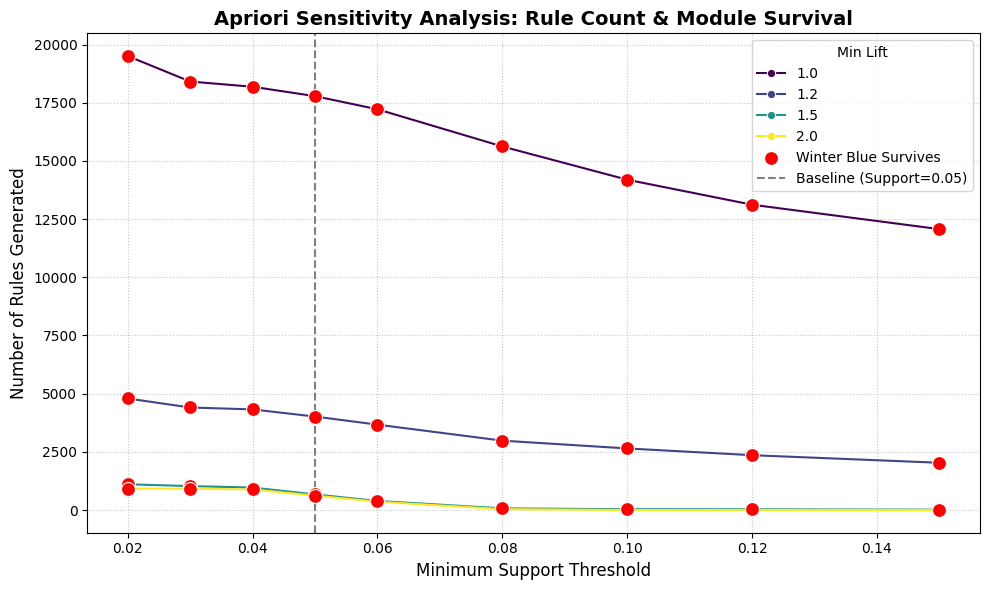

In [13]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

X_proc = color_df.astype(bool)

# grid Setup
support_list = [0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.10, 0.12, 0.15] #here i changed the support
lift_list = [1.0, 1.2, 1.5, 2.0]
conf_list = [0.1, 0.2]

rows = []

for min_sup in support_list:
# here i set the max_len，Prevent the occurrence of super combinations involving more than 5 colors from causing a RAM explosion
    frequent_itemsets = apriori(X_proc, min_support=min_sup, use_colnames=True, max_len=4)

    if frequent_itemsets.empty:
        continue

    try:
        base_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)  #Only generate rules with a confidence level of 0.1 or higher
    except ValueError:
        continue

    for min_conf in conf_list:
        for min_lift in lift_list:

            filtered_rules = base_rules[(base_rules['lift'] >= min_lift) & (base_rules['confidence'] >= min_conf)]
            num_rules = len(filtered_rules)

            winter_survives = False
            for idx, row in filtered_rules.iterrows():
                combined_colors = set(row['antecedents']).union(set(row['consequents']))
                combined_str = [str(c).lower().replace(' ', '_') for c in combined_colors]

                if any('phthalo' in s for s in combined_str) and any('prussian' in s for s in combined_str):
                    winter_survives = True
                    break

            rows.append({
                "min_support": min_sup,
                "min_confidence": min_conf,
                "min_lift": min_lift,
                "num_rules": num_rules,
                "winter_survives": winter_survives
            })

results = pd.DataFrame(rows)

summary_df = results[results['min_confidence'] == 0.1].copy()
display(summary_df.head(10))

plt.figure(figsize=(10, 6))
sns.lineplot(data=summary_df, x='min_support', y='num_rules', hue='min_lift', marker='o', palette='viridis')

survived_data = summary_df[summary_df['winter_survives'] == True]
if not survived_data.empty:
    sns.scatterplot(data=survived_data, x='min_support', y='num_rules', color='red', s=100, zorder=5, label='Winter Blue Survives')

plt.title('Apriori Sensitivity Analysis: Rule Count & Module Survival', fontsize=14, fontweight='bold')
plt.xlabel('Minimum Support Threshold', fontsize=12)
plt.ylabel('Number of Rules Generated', fontsize=12)
plt.axvline(x=0.05, color='gray', linestyle='--', label='Baseline (Support=0.05)')
plt.legend(title='Min Lift')
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

==> The sensitivity analysis shows that rule count decreases sharply as support increases, confirming that support is the main driver of rule complexity.

More importantly, the “Winter Blue” module survives across almost all tested parameter combinations, even under higher lift thresholds. This indicates that the pattern is not driven by loose thresholds but reflects a stable and structurally strong co-occurrence rule.

At support = 0.05, the model achieves a good balance between reducing noise and preserving meaningful modules, validating our M3 threshold choice.

# Hierarchical culturing

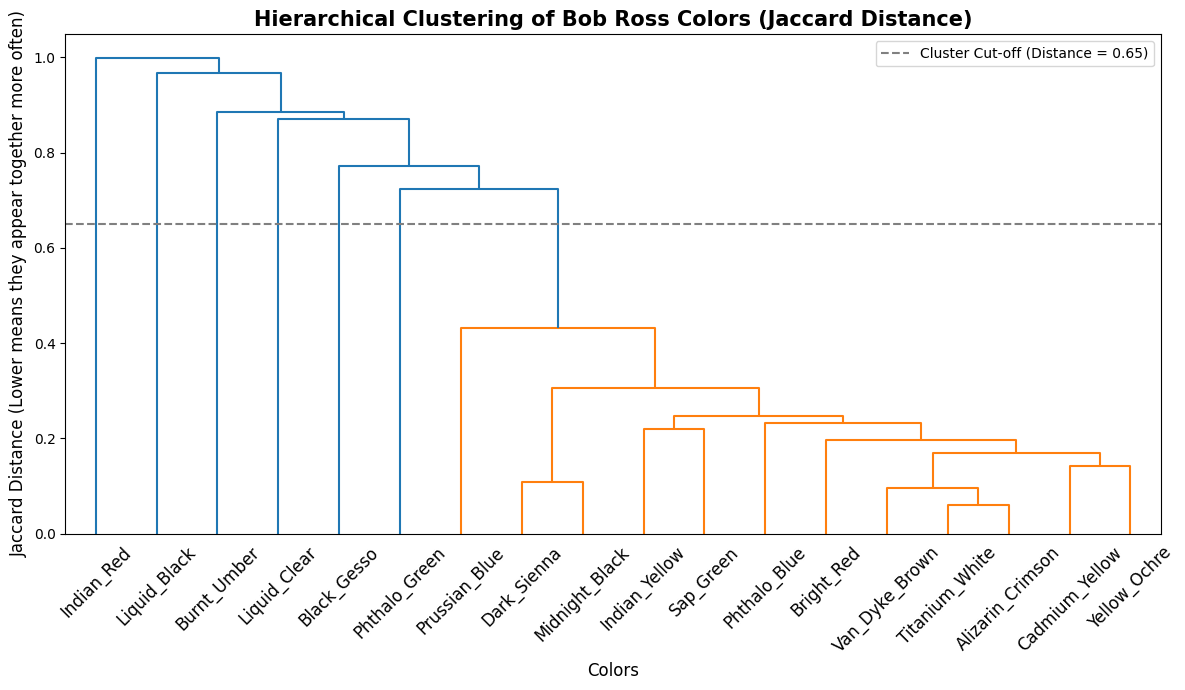

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

color_features = color_df.T

# Jaccard
jaccard_distances = pdist(color_features, metric='jaccard')

#Hierarchical Clustering
Z = linkage(jaccard_distances, method='average')

# viz
plt.figure(figsize=(12, 7))
plt.title('Hierarchical Clustering of Bob Ross Colors (Jaccard Distance)', fontsize=15, fontweight='bold')
plt.xlabel('Colors', fontsize=12)
plt.ylabel('Jaccard Distance (Lower means they appear together more often)', fontsize=12)

dendro = dendrogram(
    Z,
    labels=color_features.index,
    leaf_rotation=45,
    leaf_font_size=12,
    color_threshold=0.65
)

plt.axhline(y=0.65, color='gray', linestyle='--', label='Cluster Cut-off (Distance = 0.65)')
plt.legend()
plt.tight_layout()
plt.show()

At low distances (below 0.2), several tight pairs emerge, such as Van Dyke Brown & Titanium White, Cadmium Yellow & Yellow Ochre, and Indian Yellow & Sap Green. These combinations reflect **practical painting habits — shadow construction, warm sky blending, and foliage highlights**. This suggests that the algorithm successfully captures symmetric, frequently co-used color pairs.

The interesting thng is that, the “Winter Blue” pair (Phthalo Blue & Prussian Blue) does not form the tightest cluster. This is because Jaccard distance measures symmetric similarity. Since Phthalo Blue appears in many paintings beyond winter scenes, their overlap ratio is diluted.

# Text Mining & Semantic Alignment

  Cluster 0: ['winter', 'lake', 'moon']
  Cluster 1: ['mountain', 'lake', 'day']
  Cluster 2: ['autumn', 'stream', 'meadow']
  Cluster 3: ['sunset', 'cabin', 'forest']


,Did NOT use Winter Blue (%),USED Winter Blue (%)
theme_label,,
autumn-stream-meadow,51.52,48.48
mountain-lake-day,45.57,54.43
sunset-cabin-forest,54.21,45.79
winter-lake-moon,48.08,51.92


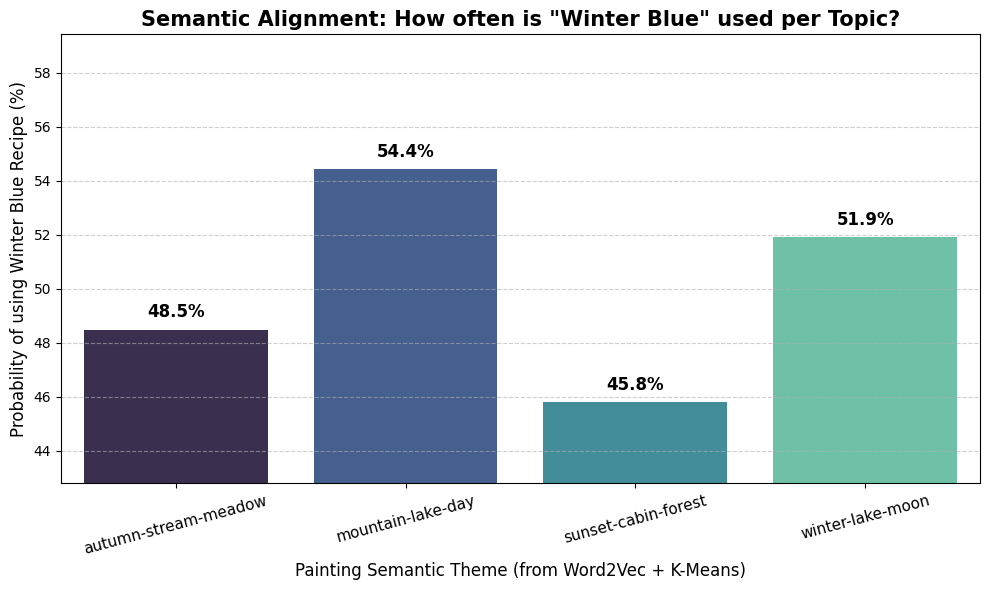

In [16]:
t()
plt.show()#install gensim
!pip install gensim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from collections import Counter

df['clean_title'] = df['clean_title'].fillna('')
tokenized_titles = df['clean_title'].apply(lambda x: str(x).split()).tolist()

w2v_model = Word2Vec(sentences=tokenized_titles, vector_size=50, window=3, min_count=1, sg=1, seed=42)

# Embeddings
def get_sentence_vector(tokens, model, size):
    valid_words = [word for word in tokens if word in model.wv.key_to_index]
    if len(valid_words) > 0:
        return np.mean(model.wv[valid_words], axis=0)
    else:
        return np.zeros(size)

X_text = np.array([get_sentence_vector(tokens, w2v_model, 50) for tokens in tokenized_titles])

#K-Means Topic Clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df['text_cluster'] = kmeans.fit_predict(X_text)

cluster_themes = {}
for i in range(k):
    cluster_words = " ".join(df[df['text_cluster'] == i]['clean_title']).split()
    stopwords = {'the', 'a', 'in', 'of', 'and', 'to', 'on'}
    meaningful_words = [w for w in cluster_words if w not in stopwords]
    top_words = [word for word, count in Counter(meaningful_words).most_common(3)]
    cluster_themes[i] = "-".join(top_words)
    print(f"  Cluster {i}: {top_words}")
df['theme_label'] = df['text_cluster'].map(cluster_themes)

df['uses_winter_blue'] = color_df['Phthalo_Blue'] & color_df['Prussian_Blue']

cross_tab = pd.crosstab(df['theme_label'], df['uses_winter_blue'], normalize='index') * 100
cross_tab.columns = ['Did NOT use Winter Blue (%)', 'USED Winter Blue (%)']
cross_tab = cross_tab.round(2)

display(cross_tab)

# viz
plt.figure(figsize=(10, 6))

min_prob = cross_tab['USED Winter Blue (%)'].min()
max_prob = cross_tab['USED Winter Blue (%)'].max()

bars = sns.barplot(x=cross_tab.index, y=cross_tab['USED Winter Blue (%)'], palette='mako')

plt.title('Semantic Alignment: How often is "Winter Blue" used per Topic?', fontsize=15, fontweight='bold')
plt.xlabel('Painting Semantic Theme (from Word2Vec + K-Means)', fontsize=12)
plt.ylabel('Probability of using Winter Blue Recipe (%)', fontsize=12)
plt.xticks(rotation=15, fontsize=11)

plt.ylim(min_prob - 3, max_prob + 5)

for p in bars.patches:
    bars.annotate(f"{p.get_height():.1f}%",
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=12, fontweight='bold',
                  color='black', xytext=(0, 6), textcoords='offset points')
# Add horizontal grid lines to make it easier for people compare heights
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layou

*I decided to use Gensim，it's a Python library for natural language processing. I used Gensim’s Word2Vec implementation to generate word embeddings from the painting titles.*

==> Above reveals four semantic themes in the painting titles:

autumn–stream–meadow, mountain–lake–day, sunset–cabin–forest, winter–lake–moon.

When examining the use of the “Winter Blue” color combination across these themes, I observed:

As expected, the winter–lake–moon theme shows a relatively high usage rate ( about 52%). However, interestingly, the mountain–lake–day theme shows an even slightly higher rate (~54%). This suggests that the “Winter Blue” palette is not strictly limited to explicitly labeled winter scenes, but more broadly associated with landscapes involving sky, water, and open space.

In contrast, themes like sunset–cabin–forest show lower usage (~46%), which aligns with warmer, earthy color palettes.

Overall, the results suggest that the Winter Blue module captures a structural landscape aesthetic rather than a purely literal “winter” concept. The semantic alignment is present, but it is functional rather than strictly seasonal.

# Business Relevance

Often, businesses box their products into rigid, literal categories (e.g., marketing "winter gear" only for snow). Our analysis suggests that underlying features are often consumed for their functional utility rather than their explicit label. If a retailer, streaming platform, or content creator can understand the true “structural aesthetic” that users engage with, they can cross-sell and bundle offerings in more strategic, non-obvious ways. **Just as Bob Ross paired Phthalo and Prussian Blue to construct space and water across seasons, businesses can design bundles based on the deeper solution a user is actually seeking—not just the surface category.**

# From M2 to M4

Across M2 to M4, the project evolved from merely detecting structure to rigorously validating and interpreting it across modeling frameworks and data modalities.

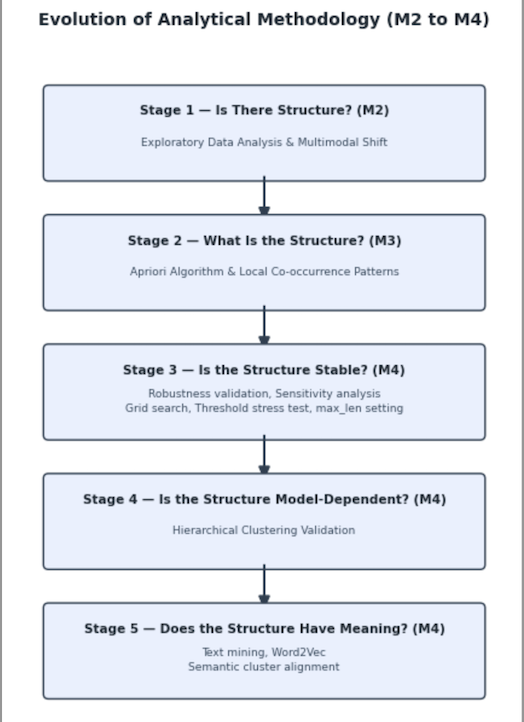